# **Milestone 1 (Continued) - Data Precprocessing**

## Importing Libraries and Modules

The cell below contains all imported libraries that are used in this notebook.

In [ ]:
! pip uninstall -y transformers
! pip install transformers==4.28.0
! pip install datasets
! pip install bert_score rouge_score jiwer evaluate

import evaluate
import pandas as pd
import tqdm
import torch
import math
import transformers
from transformers import AutoTokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset, load_metric
from ast import literal_eval
from statistics import mean

Found existing installation: transformers 4.28.0
Uninstalling transformers-4.28.0:
  Successfully uninstalled transformers-4.28.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.28.0-py3-none-any.whl (7.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Loading data set

Filtered data set was saved in Google Drive in a CSV format and is loaded as Pandas DataFrame as shown below:

In [ ]:
filtered_file_path = '/content/drive/MyDrive/recipe_data/filtered_dataset.csv'
filtered_df=pd.read_csv(filtered_file_path)
filtered_df

,title,ingredients,directions,link,source,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
3,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
4,Cheeseburger Potato Soup,"[""6 baking potatoes"", ""1 lb. of extra lean gro...","[""Wash potatoes; prick several times with a fo...",www.cookbooks.com/Recipe-Details.aspx?id=20115,Gathered,"[""baking potatoes"", ""extra lean ground beef"", ..."
...,...,...,...,...,...,...
1234471,Sweet Potato Pie,"[""1 cup butter or margarine, softened"", ""1/2 c...","[""In a mixing bowl, cream butter and sugar."", ...",www.yummly.com/recipe/Sweet-Potato-Pie-1674117,Gathered,"[""butter"", ""sugar"", ""eggs"", ""milk"", ""sweet pot..."
1234472,Croque Monsieur Panini,"[""2 tablespoons unsalted butter"", ""2 tablespoo...","[""In a small sauce pan, melt butter and add fl...",www.yummly.com/recipe/Croque-Monsieur-Panini-1...,Gathered,"[""unsalted butter"", ""flour"", ""milk"", ""black pe..."
1234473,Croque Monsieur With Cucumber Salad,"[""1/4 cup white wine vinegar"", ""1 teaspoon sug...","[""For the cucumber salad, mix the vinegar and ...",www.yummly.com/recipe/Croque-Monsieur-with-Cuc...,Gathered,"[""white wine vinegar"", ""sugar"", ""olive oil"", ""..."
1234474,Baked Pork Chops,"[""1 egg whites"", ""1 cup evaporated skim milk"",...","[""2. Beat egg white with evaporated skim milk....",www.yummly.com/recipe/Baked-Pork-Chops-1646800,Gathered,"[""egg whites"", ""milk"", ""center"", ""cornflake cr..."


## Preprocess data set

The precprocessing of the data consists of two tasks that need to be completed:
1.   Insertion of control tokens into segmented data set (training, validation and test with 60:20:20 split)
2.   Tokenize all data



### 1. Insert control tokens + Segment data set

Initially, a **for loop** implementation was considered and implemented. However, it too inefficient considering the quantity of data, which resulted in an exorbitant processing time. Various methods were researched, with the quantity of data proving to be the primary obstacle for the insertion of tokens.

**Vectorization** was also considered to accelerate process. Although vectorization effectively parallelises the processing of all data in the dataframe, its application within the Colab environment with limited RAM was infeasible. This is because vectorization is too memory itesive, applying the function to a vector containing all the input data at once, and any intermediate values are also stored in vectors, thus crashing the Colab session as all available RAM was used up.

Sources:

https://stackoverflow.com/questions/7078371/how-to-avoid-enormous-additional-memory-consumption-when-using-numpy-vectorize

https://www.exxactcorp.com/blog/Deep-Learning/how-to-speed-up-python-pandas-by-over-300x



Finally settled on using the **`apply()`** function istead. Whilst it does process the data sequentially as well, looping over a specified axis of the dataframe, it is able to compile faster by utilising Cython, C-extensions for Python. C, a compiled language, is faster than Python, an interpreted language, as a C program is converted into assembly language and then machine code, which can be directly executed by the CPU. Overall, the **`apply()`** function strikes the appropriate middle ground between memory usage and efficiency.

Sources:

https://medium.com/analytics-vidhya/hey-pandas-why-you-no-fast-loop-e7226ed97322

https://www.freecodecamp.org/news/compiled-versus-interpreted-languages/


In [ ]:
def insert_tokens(start_token, mid_token, end_token, filtered_df_column):
    """Inserts 3 types of control tokens into columns"""
    # literal_eval is able to determine the data structure from the string and convert it into a list of strings
    input_with_tokens = filtered_df_column.apply(literal_eval)
    input_with_tokens = input_with_tokens.apply(lambda x : start_token + str.join(mid_token, x) + end_token)
    return input_with_tokens

In [ ]:
def preprocess_data(filtered_df):
    """Inserts all control tokens and combines columns"""
    # 3 types of tokens required
    NER = insert_tokens("<NER_START> ", " <NEXT_NER> ", " <NER_END>", filtered_df["NER"])
    ingredients = insert_tokens("<INGR_START> ", " <NEXT_INGR> ", " <INGR_END>", filtered_df["ingredients"])
    directions = insert_tokens("<DIR_START> ", " <NEXT_DIR> ", " <DIR_END>", filtered_df["directions"])
    # 2 types of tokens required, no literal_eval needed
    title = filtered_df["title"].apply(lambda x : "<TITLE_START> " + x + " <TITLE_END>")

    # return full_recipes (reference output) and NER (input)
    full_recipes = "<RECIPE_START> " + NER + " " + ingredients + " " + directions + " " + title + " <RECIPE_END>"

    return full_recipes

In [ ]:
def df_to_dataset(dataset):
    """Convert df into list of dicts then HuggingFace Dataset"""
    list_dataset = []

    for recipe in tqdm.tqdm(dataset):
        example = {
            "recipe": recipe
        }

        list_dataset.append(example)

    return  Dataset.from_list(list_dataset)

In [ ]:
recipe_count = len(filtered_df)
training_recipe_count = math.ceil(0.6 * recipe_count)
validation_recipe_count = math.ceil((recipe_count - training_recipe_count) / 2)
test_recipe_count = recipe_count - training_recipe_count - validation_recipe_count

In [ ]:
train_recipe_dataset = preprocess_data(filtered_df[:training_recipe_count])
val_recipe_dataset = preprocess_data(filtered_df[training_recipe_count:training_recipe_count+validation_recipe_count])
test_recipe_dataset = preprocess_data(filtered_df[training_recipe_count+validation_recipe_count:recipe_count])

In [ ]:
train_recipe_dataset = df_to_dataset(train_recipe_dataset)
val_recipe_dataset = df_to_dataset(val_recipe_dataset)
test_recipe_dataset = df_to_dataset(test_recipe_dataset)

100%|██████████| 246895/246895 [00:00<00:00, 1940098.29it/s]


As shown below, the control tokens have been successfully added to the input:

In [ ]:
train_recipe_dataset[0]['recipe']

'<RECIPE_START> <NER_START> brown sugar <NEXT_NER> milk <NEXT_NER> vanilla <NEXT_NER> nuts <NEXT_NER> butter <NEXT_NER> bite size shredded rice biscuits <NER_END> <INGR_START> 1 c. firmly packed brown sugar <NEXT_INGR> 1/2 c. evaporated milk <NEXT_INGR> 1/2 tsp. vanilla <NEXT_INGR> 1/2 c. broken nuts (pecans) <NEXT_INGR> 2 Tbsp. butter or margarine <NEXT_INGR> 3 1/2 c. bite size shredded rice biscuits <INGR_END> <DIR_START> In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. <NEXT_DIR> Stir over medium heat until mixture bubbles all over top. <NEXT_DIR> Boil and stir 5 minutes more. Take off heat. <NEXT_DIR> Stir in vanilla and cereal; mix well. <NEXT_DIR> Using 2 teaspoons, drop and shape into 30 clusters on wax paper. <NEXT_DIR> Let stand until firm, about 30 minutes. <DIR_END> <TITLE_START> No-Bake Nut Cookies <TITLE_END> <RECIPE_END>'

In [ ]:
val_recipe_dataset[0]['recipe']

'<RECIPE_START> <NER_START> broccoli <NEXT_NER> sour cream <NEXT_NER> parmesan cheese <NEXT_NER> lemon juice <NEXT_NER> tarragon <NEXT_NER> dried basil <NEXT_NER> thyme <NEXT_NER> salt <NEXT_NER> eggs <NEXT_NER> egg whites <NEXT_NER> red peppers <NEXT_NER> sour cream <NEXT_NER> salt <NEXT_NER> lemon zest <NEXT_NER> lemon juice <NEXT_NER> garlic <NEXT_NER> mayonnaise <NEXT_NER> salt <NEXT_NER> fresh ground black pepper <NER_END> <INGR_START> 1 lb broccoli, cut into 1 inch pieces and cooked until very tender <NEXT_INGR> 1/2 cup fat free sour cream <NEXT_INGR> 1/4 cup parmesan cheese <NEXT_INGR> 2 teaspoons lemon juice <NEXT_INGR> 1/2 teaspoon dried tarragon <NEXT_INGR> 1/2 teaspoon dried basil <NEXT_INGR> 1/4 teaspoon dried thyme <NEXT_INGR> salt and pepper <NEXT_INGR> 3 eggs <NEXT_INGR> 2 egg whites <NEXT_INGR> sauce option 1 <NEXT_INGR> 12 ounces roasted red peppers, drained <NEXT_INGR> 4 tablespoons fat free sour cream <NEXT_INGR> salt <NEXT_INGR> sauce option 2 <NEXT_INGR> 1/2 teaspo

In [ ]:
test_recipe_dataset[0]['recipe']

'<RECIPE_START> <NER_START> yogurt <NEXT_NER> scoops <NEXT_NER> packets Splenda <NER_END> <INGR_START> 16 oz plain yogurt <NEXT_INGR> 2 c fresh or frozen unsweetened mixed berries <NEXT_INGR> 4 scoops (about 80 g) vanilla or strawberry whey-protein powder <NEXT_INGR> 2 packets Splenda (optional) <INGR_END> <DIR_START> Line a 2-cup mesh strainer with a paper coffee filter and place it over a mixing bowl. Fill the filter with the yogurt, cover with a clean cloth or waxed paper, and set the bowl (with strainer inside) in the refrigerator for several hours. Much of the liquid from the yogurt will drain into the bowl, resulting in thicker yogurt. In a blender, puree the berries along with the whey-protein powder and Splenda. Once the yogurt has drained, place it in a large bowl and stir in the berry puree. <NEXT_DIR>  <NEXT_DIR> Serve in 1-cup portions and store for up to 3 days. <DIR_END> <TITLE_START> Berry-High Protein Yogurt  <TITLE_END> <RECIPE_END>'

### 2. Tokenize data

Insert control tokens, split data set into training, validation and test set. Use fast tokenizer to speed up tokenization process.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({"pad_token": "<PAD>", "bos_token": "<RECIPE_START>", "eos_token": "<RECIPE_END>"})
tokenizer.add_tokens(["<NER_START>", "<NEXT_NER>", "<NER_END>", "<INGR_START>", "<NEXT_INGR>", "<INGR_END>", "<DIR_START>", "<NEXT_DIR>", "<DIR_END>", "<TITLE_START>", "<TITLE_END>"])

11

All recipes (including tokens) have a word count of less than 1024, which is the token limit for a GPT-2 model. Thus, padding will be required. Furthermore, truncation should also be put in place, as the GPT-2 tokenizer generates tokens based on byte pair encoding where tokens are generated at a sub-word level. Thus, even with a word count of less than 1000, more than 1024 tokens can still be generated.

GPT2 model accpets a maximum input of 1024 tokens. Thus, truncation is definitely required. Truncation can help to reduce memory usage and make training faster. However, we do not want to lose too much information when truncating recipes. Thus, we want to keep at least 98% of recipes untruncated.

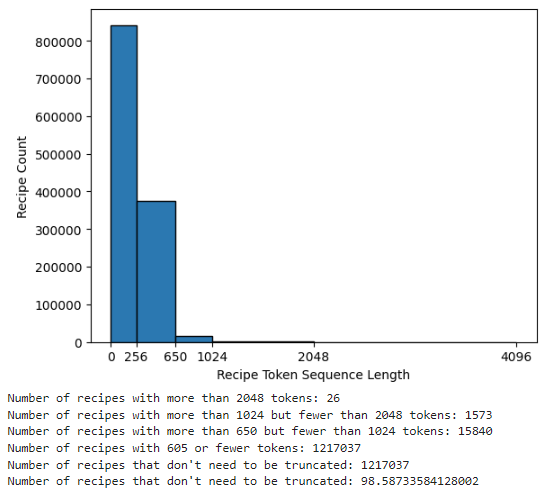

Padding is done so that all tensors are of the same length 650, enabling batching to be done. .to(device) done to send data to GPU where the triaining process will be conducted.

In [ ]:
max_recipe_length = 650

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

def tokenize_function(recipe):
    "Tokenize, pad, and truncate recipe entry converted to PyTorch tensor"
    model_input = tokenizer(recipe["recipe"], max_length=max_recipe_length, padding="max_length", truncation=True, return_tensors="pt").to(device)

    return model_input

def tokenize_dataset(dataset):
    "Batch tokenizes recipe entries in dataset"
    dataset = dataset.map(tokenize_function, batched=True)

    # remove unnecessary column to reduce memory usage
    dataset = dataset.remove_columns(["recipe"])

    return dataset

The **`.map`** function allows the dataset to be tokenized in batches, significantly reducing the processing time.

In [ ]:
train_recipe_dataset = tokenize_dataset(train_recipe_dataset)
val_recipe_dataset = tokenize_dataset(val_recipe_dataset)
test_recipe_dataset = tokenize_dataset(test_recipe_dataset)

Map:   0%|          | 0/740686 [00:00<?, ? examples/s]

Map:   0%|          | 0/246895 [00:00<?, ? examples/s]

Map:   0%|          | 0/246895 [00:00<?, ? examples/s]

In [ ]:
train_recipe_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 740686
})

In [ ]:
val_recipe_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 246895
})

In [ ]:
test_recipe_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 246895
})

As shown below, the recipes have been successfully tokenized, padded and truncated:

In [ ]:
tokenizer.decode(train_recipe_dataset[0]['input_ids'])

'<RECIPE_START> <NER_START> brown sugar <NEXT_NER> milk <NEXT_NER> vanilla <NEXT_NER> nuts <NEXT_NER> butter <NEXT_NER> bite size shredded rice biscuits <NER_END> <INGR_START> 1 c. firmly packed brown sugar <NEXT_INGR> 1/2 c. evaporated milk <NEXT_INGR> 1/2 tsp. vanilla <NEXT_INGR> 1/2 c. broken nuts (pecans) <NEXT_INGR> 2 Tbsp. butter or margarine <NEXT_INGR> 3 1/2 c. bite size shredded rice biscuits <INGR_END> <DIR_START> In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. <NEXT_DIR> Stir over medium heat until mixture bubbles all over top. <NEXT_DIR> Boil and stir 5 minutes more. Take off heat. <NEXT_DIR> Stir in vanilla and cereal; mix well. <NEXT_DIR> Using 2 teaspoons, drop and shape into 30 clusters on wax paper. <NEXT_DIR> Let stand until firm, about 30 minutes. <DIR_END> <TITLE_START> No-Bake Nut Cookies <TITLE_END> <RECIPE_END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

In [ ]:
tokenizer.decode(val_recipe_dataset[0]['input_ids'])

'<RECIPE_START> <NER_START> broccoli <NEXT_NER> sour cream <NEXT_NER> parmesan cheese <NEXT_NER> lemon juice <NEXT_NER> tarragon <NEXT_NER> dried basil <NEXT_NER> thyme <NEXT_NER> salt <NEXT_NER> eggs <NEXT_NER> egg whites <NEXT_NER> red peppers <NEXT_NER> sour cream <NEXT_NER> salt <NEXT_NER> lemon zest <NEXT_NER> lemon juice <NEXT_NER> garlic <NEXT_NER> mayonnaise <NEXT_NER> salt <NEXT_NER> fresh ground black pepper <NER_END> <INGR_START> 1 lb broccoli, cut into 1 inch pieces and cooked until very tender <NEXT_INGR> 1/2 cup fat free sour cream <NEXT_INGR> 1/4 cup parmesan cheese <NEXT_INGR> 2 teaspoons lemon juice <NEXT_INGR> 1/2 teaspoon dried tarragon <NEXT_INGR> 1/2 teaspoon dried basil <NEXT_INGR> 1/4 teaspoon dried thyme <NEXT_INGR> salt and pepper <NEXT_INGR> 3 eggs <NEXT_INGR> 2 egg whites <NEXT_INGR> sauce option 1 <NEXT_INGR> 12 ounces roasted red peppers, drained <NEXT_INGR> 4 tablespoons fat free sour cream <NEXT_INGR> salt <NEXT_INGR> sauce option 2 <NEXT_INGR> 1/2 teaspo

In [ ]:
tokenizer.decode(test_recipe_dataset[0]['input_ids'])

'<RECIPE_START> <NER_START> yogurt <NEXT_NER> scoops <NEXT_NER> packets Splenda <NER_END> <INGR_START> 16 oz plain yogurt <NEXT_INGR> 2 c fresh or frozen unsweetened mixed berries <NEXT_INGR> 4 scoops (about 80 g) vanilla or strawberry whey-protein powder <NEXT_INGR> 2 packets Splenda (optional) <INGR_END> <DIR_START> Line a 2-cup mesh strainer with a paper coffee filter and place it over a mixing bowl. Fill the filter with the yogurt, cover with a clean cloth or waxed paper, and set the bowl (with strainer inside) in the refrigerator for several hours. Much of the liquid from the yogurt will drain into the bowl, resulting in thicker yogurt. In a blender, puree the berries along with the whey-protein powder and Splenda. Once the yogurt has drained, place it in a large bowl and stir in the berry puree. <NEXT_DIR>  <NEXT_DIR> Serve in 1-cup portions and store for up to 3 days. <DIR_END> <TITLE_START> Berry-High Protein Yogurt  <TITLE_END> <RECIPE_END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><P

# **Milestone 2 & 4 - Formulate and Fine-Tune Base Architecture + Initial Evaluation**

Need to compute metrics and find way to compare training of different models: bertscore, wer, meteor, rouge, bleu

The idea of mixed precision training is that no all variables need to be stored in full (32-bit) floating point precision. If we can reduce the precision the variales and their computations are faster. The main advantage comes from saving the activations in half (16-bit) precision. Although the gradients are also computed in half precision they are converted back to full precision for the optimization step so no memory is saved here. Since the model is present on the GPU in both 16-bit and 32-bit precision this can use more GPU memory (1.5x the original model is on the GPU), especially for small batch sizes. Since some computations are performed in full and some in half precision this approach is also called mixed precision training. Enabling mixed precision training is also just a matter of setting the fp16 flag to True, shaved training time from 27h20min to 11h45min:

Each validation run only takes 28min as only forward pass is needed without any back propagation and adjustment of weights.

Computing the meteor score takes too long (>1 hour) due to the large quantity of data and significant processing that needs to be done per prediction/label. Thus, it is just not beneficial and we substitute its semantic similarity with BERTScore instead (that is also based on cosim).

In [ ]:
# load evaluative metrics to be used on validation set
rouge = evaluate.load("rouge")
meteor = load_metric("meteor")
sbert_cosine = evaluate.load("transZ/sbert_cosine")
wer = evaluate.load("wer")
bleu = evaluate.load("bleu")

<ipython-input-21-eaeac80b5d1b>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  meteor = load_metric("meteor")
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Load pre-trained GPTLMHeadModel for specific purpose of casual language modelling
# GPT2-Small used to prevent overfitting and reduce training time (fewer parameters)
# uses cross-entropy loss


model = GPT2LMHeadModel.from_pretrained("gpt2")
# The number of new tokens in the embedding matrix. Increasing the size will add newly initialized vectors at the end. Reducing the size will remove vectors from the end.
model.resize_token_embeddings(len(tokenizer))
# both the model and the data need to be on the GPU to conduct training there
model = model.to(device)

In [ ]:
def preprocess_logits_for_metrics(logits, labels):
    """
    Workaround to avoid storing too many tensors that are not needed.
    """
    # takes the most likely tokens from the output logits to formulate the predictions
    pred_ids = torch.argmax(logits, dim=-1)

    return pred_ids, labels

def compute_metrics(pred):

    labels_ids = pred.label_ids
    pred_ids = pred.predictions[0]

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # ~5min
    rouge_output = rouge.compute(
        predictions=pred_str,
        references=label_str,
        rouge_types=["rouge2"],
        use_aggregator=True,
    )["rouge2"]

    # metrics take into account semantic similarity are siginificantly slower, thus a smaller subset of the validation results are used
    meteor_output = meteor.compute(
        predictions=pred_str[:25000],
        references=label_str[:25000],
    )["meteor"]

    sbert_cosine_output = sbert_cosine.compute(
        predictions=pred_str[:25000],
        references=label_str[:25000],
    )["score"]

    wer_output = wer.compute(
        predictions=pred_str,
        references=label_str,
    )

    label_str = [[label] for label in label_str]

    # This metric takes as input a list of predicted sentences and a list of lists of reference sentences (since each predicted sentence can have multiple references)
    bleu_output = bleu.compute(
        predictions=pred_str,
        references=label_str,
    )["bleu"]

    return {
        "R2": round(rouge_output, 4),
        "METEOR": round(meteor_output, 4),
        "SBert": round(mean(sbert_cosine_output), 4),
        "WER": round(wer_output, 4),
        "BLEU": round(bleu_output, 4),
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/checkpoints",
    save_strategy="epoch",
    logging_dir="/content/drive/MyDrive/runs/full_training2",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    optim="adamw_torch",
    learning_rate=1e-3,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    fp16=True,
    label_names=["input_ids"]
)

# mlm set to False, as we are conducting casual language modelling, not masked language modelling
# forms batches from the training and validation dataset
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

#Trainer class shuffles the training dataset at every epoch, preventing overfitting
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_recipe_dataset,
    eval_dataset=val_recipe_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

trainer.train()
trainer.save_model("/content/drive/MyDrive/ML_Chef_models/recipe_model2")

# to evaluate model change the eval_dataset to test_recipe_dataset
# and instead of trainer.train() use trainer.evaluate()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
Loading model from /content/drive/MyDrive/checkpoints/checkpoint-92586.
***** Running training *****
  Num examples = 740,686
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 185,172
  Number of trainable parameters = 124,450,560
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 92586
  Will skip the first 2 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can install the latest version 

0it [00:00, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,R2,Meteor,Sbert,Wer,Bleu
3,0.955600,1.398415,0.452500,0.682600,0.976700,0.545000,0.530600
4,0.898000,1.368506,0.433200,0.680700,0.964700,0.666800,0.500200


***** Running Evaluation *****
  Num examples = 246895
  Batch size = 16


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2/snapshots/b8ef00830037f9868450f778081ea683e900fe39/config.json
Model config BertConfig {
  "_name_or_path": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 250037
}



loading file vocab.txt from cache at None
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2/snapshots/b8ef00830037f9868450f778081ea683e900fe39/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2/snapshots/b8ef00830037f9868450f778081ea683e900fe39/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2/snapshots/b8ef00830037f9868450f778081ea683e900fe39/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2/snapshots/b8ef00830037f9868450f778081ea683e900fe39/config.json
Model config BertConfig {
  "_name_or_path":

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2/snapshots/b8ef00830037f9868450f778081ea683e900fe39/pytorch_model.bin
All model checkpoint weights were used when initializing BertModel.

All the weights of BertModel were initialized from the model checkpoint at sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertModel for predictions without further training.
Saving model checkpoint to /content/drive/MyDrive/checkpoints/checkpoint-138879
Configuration saved in /content/drive/MyDrive/checkpoints/checkpoint-138879/config.json
Configuration saved in /content/drive/MyDrive/checkpoints/checkpoint-138879/generation_config.json
Model weights saved in /content/drive/MyDrive/checkpoints/checkpoint-138879/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 246895
  Batch

In [ ]:
generation_kwargs = {
    "max_length": 512,
    "min_length": 64,
    "top_k":  5,
    "temperature": 0.9,
    "pad_token_id": 50257,
    "do_sample": True, #for top k sampling
}

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

def infer(inp, model):
    inp = tokenizer(inp, return_tensors="pt")
    X = inp["input_ids"].to(device)
    a = inp["attention_mask"].to(device)
    output = model.generate(X, attention_mask=a, **generation_kwargs )
    output = tokenizer.decode(output[0])
    return output

def postprocess_recipe(recipe):
    full_recipe = []
    recipe_words = recipe.split()

    for word in recipe_words:
        if word == "<RECIPE_END>":
            break
        else:
            full_recipe.append(word)

    title = full_recipe[full_recipe.index("<TITLE_START>")+1:full_recipe.index("<TITLE_END>")]
    ingredients = full_recipe[full_recipe.index("<INGR_START>")+1:full_recipe.index("<INGR_END>")]
    directions = full_recipe[full_recipe.index("<DIR_START>")+1:full_recipe.index("<DIR_END>")]

    full_title = ""
    ingredient = ""
    direction = ""

    for title_word in title:
        full_title = full_title + title_word + " "

    print(full_title)
    print("=" * 150)
    print("Ingredients:")

    for word in ingredients:
      if word == "<NEXT_INGR>":
          print(f"- {ingredient}")
          ingredient = ""
      else:
          ingredient = ingredient + word + " "

    print(f"- {ingredient}")
    print("-" * 150)
    print("Directions:")

    for word in directions:
      if word == "<NEXT_DIR>":
          print(f"- {direction}")
          direction = ""
      else:
          direction = direction + word + " "

    if direction != "":
      print(f"- {direction}")



In [ ]:
input1 = "<RECIPE_START> <NER_START> macaroni <NEXT_NER> butter <NEXT_NER> salt <NEXT_NER> bacon <NEXT_NER> milk <NEXT_NER> flour <NEXT_NER> pepper <NEXT_NER> cream corn <NER_END>"
input2 = "<RECIPE_START> <NER_START> provolone cheese <NEXT_NER> bacon <NEXT_NER> bread <NER_END>"
input3 = "<RECIPE_START> <NER_START> pork chop <NEXT_NER> potatoes <NEXT_NER> aspargus <NEXT_NER> salt <NEXT_NER> pepper <NEXT_NER> olive oil <NEXT_NER> butter <NER_END>"

training_model1 = GPT2LMHeadModel.from_pretrained("/content/drive/MyDrive/ML_Chef_models/recipe_model2")
training_model1 = training_model1.to(device)

postprocess_recipe(infer(input1, training_model1))
postprocess_recipe(infer(input2, training_model1))
postprocess_recipe(infer(input3, training_model1))

Creamy Macaroni And Corn 
Ingredients:
- 1 c. uncooked macaroni 
- 2 Tbsp. butter 
- 1 tsp. salt 
- 3 strips bacon, cut up 
- 1 c. milk 
- 1 Tbsp. flour 
- dash of pepper 
- 1 can cream corn 
------------------------------------------------------------------------------------------------------------------------------------------------------
Directions:
- In a saucepan, cook macaroni until tender. 
- Drain. 
- In a saucepan, melt butter. 
- Stir in flour and seasonings. 
- Add milk, stirring until thickened and smooth. 
- Stir in corn, bacon and macaroni. 
- Cook until thoroughly heated. 
- Makes 3 servings. 
Bacon Wrapped Cheese 
Ingredients:
- 1 lb provolone cheese 
- 1 lb bacon 
- 1 (1 ounce) package ranch dressing mix 
- 1 loaf French bread 
------------------------------------------------------------------------------------------------------------------------------------------------------
Directions:
- Slice cheese length wise and cut into strips. 
- Wrap bacon around cheese. 
- Mi

In [ ]:
input4 = "<RECIPE_START> <NER_START> flour <NEXT_NER> baking powder <NEXT_NER> bananas <NEXT_NER> eggs <NEXT_NER> vanilla extract <NEXT_NER> milk <NEXT_NER> butter <NER_END>"
postprocess_recipe(infer(input4, training_model1))

Banana Waffles 
Ingredients:
- 2 c. flour 
- 2 tsp. baking powder 
- 1 c. mashed bananas 
- 2 eggs, lightly beaten 
- 1 tsp. vanilla extract 
- 1 1/3 c. milk 
- 2 Tbsp. butter 
------------------------------------------------------------------------------------------------------------------------------------------------------
Directions:
- Mix flour and baking powder in a large bowl. 
- Combine bananas, eggs, vanilla and milk in another bowl; mix well. 
- Add flour mixture and butter to banana mixture and stir just until dry ingredients are moistened. 
- Pour batter into a hot, lightly greased skillet or waffle iron. 


In [ ]:
input5 = "<RECIPE_START> <NER_START> chickpeas <NEXT_NER> king prawns <NEXT_NER> white wine <NEXT_NER> fish stock <NEXT_NER> onions <NEXT_NER> garlic <NEXT_NER> tomatoes <NEXT_NER> olive oil <NEXT_NER> salt <NEXT_NER> pepper <NER_END>"
salad = infer(input5, training_model1)
postprocess_recipe(salad)

King Prawn Stew 
Ingredients:
- 1 1/2 cups chickpeas, cooked 
- 1 1/2 cups king prawns, raw (peeled and deveined) 
- 1 cup dry white wine 
- 1/2 cup fish stock 
- 1 1/2 cups onions, sliced 
- 3 garlic cloves, sliced 
- 3 tomatoes, sliced 
- 1 tablespoon olive oil 
- 2 teaspoons salt 
- 1 teaspoon pepper 
------------------------------------------------------------------------------------------------------------------------------------------------------
Directions:
- Heat the olive oil in a large pot. 
- Add the garlic and onion, cook until softened. 
- Add the tomatoes and saute for a minute. 
- Add the chickpeas, prawns, fish stock, and wine. 
- Add the salt and pepper, bring to a boil. 
- Reduce the heat and simmer for 10 minutes. 
- Serve with rice. 
- Enjoy! 


In [ ]:
input6 = "<RECIPE_START> <NER_START> spaghetti <NEXT_NER> smoked salmon <NEXT_NER> leek <NEXT_NER> chilli flakes <NEXT_NER> fresh basil <NEXT_NER> garlic <NEXT_NER> parmesan cheese <NEXT_NER> olive oil <NEXT_NER> salt <NEXT_NER> black pepper <NER_END>"
pasta = infer(input6, training_model1)
postprocess_recipe(pasta)

Spaghetti Alla Pesto With Smoked Salmon 
Ingredients:
- 1 lb spaghetti 
- 1/2 lb smoked salmon, thinly sliced 
- 1 leek, sliced 
- 1 pinch chilli flakes 
- 2 ounces fresh basil, chopped 
- 2 garlic cloves, crushed 
- 1/4 cup parmesan cheese, grated 
- 1 tablespoon olive oil 
- 1/2 teaspoon salt 
- 1/4 teaspoon black pepper 
------------------------------------------------------------------------------------------------------------------------------------------------------
Directions:
- In a large pot of salted boiling water, cook the pasta until al dente. Drain well. 
- Heat the oil in a large skillet over medium-high heat. Add the leek, chilli flakes and garlic; saute for about 3-5 minutes or until tender. 
- Stir in the salmon and cook until heated through. 
- Toss in the cooked pasta, basil, parmesan, salt and pepper. Serve at once. 


In [ ]:
input7 = "<RECIPE_START> <NER_START> chicken thighs <NEXT_NER> mushrooms <NEXT_NER> chicken stock <NEXT_NER> red wine <NEXT_NER> bay leaves <NEXT_NER> tomato paste <NEXT_NER> rosemary <NEXT_NER> fresh parsley <NEXT_NER> lemon juice <NEXT_NER> garlic <NEXT_NER> shallots <NEXT_NER> olive oil <NEXT_NER> salt <NEXT_NER> pepper <NER_END>"
meat = infer(input7, training_model1)
postprocess_recipe(meat)

Chicken Thighs With Mushrooms 
Ingredients:
- 2 lbs chicken thighs 
- 12 ounces fresh mushrooms, sliced 
- 1 1/2 cups low sodium chicken stock 
- 1 cup dry red wine 
- 2 bay leaves 
- 1/4 cup tomato paste 
- 2 sprigs fresh rosemary 
- 1/4 cup fresh parsley, chopped 
- 2 tablespoons fresh lemon juice 
- 2 garlic cloves, chopped 
- 1/4 cup shallots or 1/4 cup white onion, chopped 
- 3 tablespoons olive oil, divided 
- salt 
- pepper 
------------------------------------------------------------------------------------------------------------------------------------------------------
Directions:
- In a large saucepan combine stock, wine, bay leaf, tomato paste, rosemary and 1/4 cup of the parsley. 
- Bring to a boil and reduce to simmer. 
- In a medium saucepan, heat 1 tablespoon of the olive oil and brown the chicken thighs on both sides. 
- Transfer to a bowl. 
- In the same saucepan, heat the remaining 1 tablespoon olive oil and cook the shallots/onion until softened (about 3 minutes). 